# Image Preparation Lab

In [16]:
import cv2
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt

from bcd.data.prep.image.clean import DICOMArtifactRemover

In [17]:
PATH = "data/raw/CBIS-DDSM/Calc-Test_P_00041_LEFT_CC/08-29-2017-DDSM-52275/1.000000-full mammogram images-92812/1-1.dcm"
IMG_SIZE = (256,256)
ftype = os.path.splitext(PATH)[1]
'dcm' in ftype

True

## Raw Image

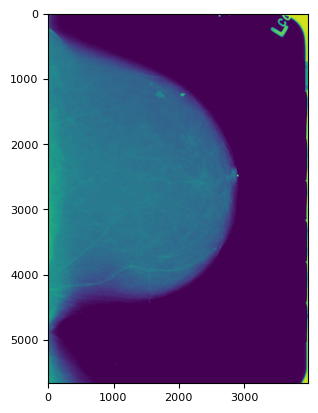

In [18]:
dataset = pydicom.dcmread(PATH)
img = dataset.pixel_array
plt.imshow(img)

## Artifact Removal

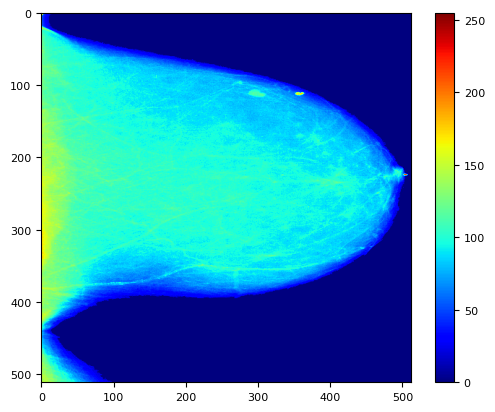

In [19]:
ar = DICOMArtifactRemover()
img_ar, _ = ar.process_image(filepath=PATH)
ar.display(img=img_ar)

In [20]:
ar.run(n=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Artifact Removal Complete!
Time = 4.016 sec


In [21]:
img_clean = ar.read_image(filepath="data/meta/1_staged/CBIS-DDSM/Calc-Training_P_02105_LEFT_CC/08-07-2016-DDSM-23146/1.000000-full mammogram images-44812/1-1.png")

## Pectoral Muscle Removal

In [22]:
HIGH_INTENSITY_THRESHOLD = 0.8
KERNEL_SIZE_MORPH = 3
KERNEL_SIZE_SMOOTH = 25
N_MORPH = 7

In [23]:
def max_pix_val(dtype):
    """Returns the maximum pixel value given the dtype"""
    if dtype == np.dtype("uint8"):
        maxval = 2**8 - 1
    elif dtype == np.dtype("uint16"):
        maxval = 2**16 - 1
    else:
        raise Exception("Unknown dtype found in input image array")
    return maxval

In [24]:
ar = DICOMArtifactRemover()
img = ar.read_image(filepath="data/meta/1_staged/CBIS-DDSM/Calc-Training_P_02105_LEFT_CC/08-07-2016-DDSM-23146/1.000000-full mammogram images-44812/1-1.png")


In [25]:
img_equ = cv2.equalizeHist(img)
high_intensity_threshold = int(img.max()*HIGH_INTENSITY_THRESHOLD)
maxval = max_pix_val(img.dtype)
_, img_bin = cv2.threshold(img_equ, high_intensity_threshold, maxval=maxval, type=cv2.THRESH_BINARY)
pect_marker_img = np.zeros(img_bin.shape, dtype=np.int32)


In [30]:
contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
pect_mask_init =  max(contours, key=cv2.contourArea)
pect_mask_init = pect_mask_init.astype('uint8')

In [31]:

kernel = np.ones((KERNEL_SIZE_MORPH, KERNEL_SIZE_MORPH), dtype=np.uint8)
pect_mask_eroded = cv2.erode(pect_mask_init, kernel, iterations=N_MORPH)
pect_mask_eroded.shape
pect_mask_eroded = pect_mask_eroded.reshape(pect_mask_eroded.shape[0],-1)
pect_marker_img[pect_mask_eroded > 0] = 255

(2093, 1, 2)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 512 but corresponding boolean dimension is 2093

In [14]:
pect_mask_dilated = cv2.dilate(pect_mask_init, kernel, iterations=N_MORPH)
pect_marker_img[pect_mask_dilated == 0] = 128
pect_marker_img[img == 0] = 64

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
# Watershed segmentation.
img_equ_3c = cv2.cvtColor(img_equ, cv2.COLOR_GRAY2BGR)
cv2.watershed(img_equ_3c, pect_marker_img)
img_equ_3c[pect_marker_img == -1] = (0, 0, 255)

In [ ]:
# Extract only the breast and smooth.
breast_only_mask = pect_marker_img.copy()
breast_only_mask[breast_only_mask == -1] = 0
breast_only_mask = breast_only_mask.astype(np.uint8)
breast_only_mask[breast_only_mask != 128] = 0
breast_only_mask[breast_only_mask == 128] = 255
kernel_ = np.ones((KERNEL_SIZE_SMOOTH, KERNEL_SIZE_SMOOTH), dtype=np.uint8)
breast_only_mask = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, 
                                    kernel_)
img_breast_only = cv2.bitwise_and(img_equ, breast_only_mask)

In [ ]:
plt.imshow(img_breast_only, cmap='jet')